# Лабораторная работа 6

   по теме
                 
   **Прогноз успеха фильмов по обзорам**
   
   ****

   Выполнил студент

   Группы БСТ1801

   Харатишвили Заза

In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from pydash import map_

In [3]:
# Загружаем датасет
from keras.datasets import imdb
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)

# Обьединяем данные в доль одной оси
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets),axis=0)
print("Количество оценок: ", len(targets))
print("Количество обзоров: ", len(data))

Количество оценок:  50000
Количество обзоров:  50000


In [4]:
print("Категории:", np.unique(targets)) # Положительный или отрицательный обзоры
print("Количество уникальных слов:", len(np.unique(np.hstack(data))))
length = [len(i) for i in data]
print("Средний размер обзора:", np.mean(length))
print("Стандартное отклонение:", round(np.std(length)))

Категории: [0 1]
Количество уникальных слов: 9998
Средний размер обзора: 234.75892
Стандартное отклонение: 173


In [5]:
# Посмотрим на первый обзор из датасета
print("Номер:", targets[1])
print(data[1])

# Преобразуем индексы в слова
index = imdb.get_word_index() # Получаем слова и их индексы
reverse_index = dict([(value, key) for (key, value) in index.items()])
decoded = " ".join( [reverse_index.get(i - 3, "#") for i in data[1]] ) # Заменим неизвестные слова на #
print("\n Текст обзора: ", decoded)
print("\n Форма первого обзора: ", tf.shape(data[1]))

Номер: 0
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]

 Текст обзора:  # big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and

In [6]:
# Подготовим данные
# Заполним нулями каждый обзор, чтобы размер был 10000 чисел
# Это необходимо, потому что каждый элемент входных данных должен иметь одинаковый размер
print("\n Форма обзора: ",tf.shape(data[1]))

def vectorize(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

data = vectorize(data)
print("\n Преобразованный обзор: ", data[1])
print("\n Форма преобразованного обзора: ", tf.shape(data[1]))

targets = np.array(targets).astype("float32") # Приведем к типу float32
print("\n Оценка фильма: ", targets[1])


 Форма обзора:  tf.Tensor([189], shape=(1,), dtype=int32)

 Преобразованный обзор:  [0. 1. 1. ... 0. 0. 0.]

 Форма преобразованного обзора:  tf.Tensor([10000], shape=(1,), dtype=int32)

 Оценка фильма:  0.0


In [7]:
# Разделим датасет на обучающий и тестировочный наборы. Обучающий 40 000 обзоров, тестовый — 10 000.
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]

print(tf.shape(test_x))
print(tf.shape(test_y))

tf.Tensor([10000 10000], shape=(2,), dtype=int32)
tf.Tensor([10000], shape=(1,), dtype=int32)


In [8]:
# Создадим и обучим модель 
model = Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary() # Получаем сводку сети

# Компилируем модель
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

results = model.fit(train_x, train_y, epochs= 2, batch_size = 500, validation_data = (test_x, test_y))

# Проведем оценку работы модели
print("Точность обучения:", np.mean(results.history["val_acc"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500050    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 505,201
Trainable params: 505,201
Non-trai

In [9]:
#Проверим работу модели при разных размерах вектора данных
models_list = [] #Массив для сохранения моделей
vector_sizes = [1000, 2000, 5000, 10000] #Массив с разными значениями размера вектора представления текста

for vector_size in vector_sizes: #Перебираем в цикле модель
    # Подгружаем данные
    (training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=vector_size)
    # Задаем одну ось
    data = np.concatenate((training_data, testing_data), axis=0)
    targets = np.concatenate((training_targets, testing_targets), axis=0)
    # Дополняем обзор нулями до vector_size
    data = vectorize(data, vector_size)
    # Приводим оценки к типу float32
    targets = np.array(targets).astype("float32")
    # Разделим датасет
    test_x = data[:vector_size]
    test_y = targets[:vector_size]
    train_x = data[vector_size:]
    train_y = targets[vector_size:]
    
    # Создадим модель
    model = models.Sequential()
    model.add(layers.Dense(50, activation = "relu", input_shape=(vector_size, )))
    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
    model.add(layers.Dense(1, activation = "sigmoid"))
    model.summary()
    
    # Компилируем модель
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    
    # Обучаем модель
    results = model.fit(train_x, train_y, epochs= 2, batch_size = 500, validation_data = (test_x, test_y))
    
    # Записываем модель в массив models_list
    models_list.append(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                50050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 55,201
Trainable params: 55,201
Non-trai

In [24]:
# Функция построения графиков для сравниения моделей
def build_plot(history, title):
    fig, ax = plt.subplots(1,2,figsize=(13,6))
    ax[0].plot(history.history['loss'], 'g', label= 'loss')
    ax[0].plot(history.history['val_loss'], label= 'val_loss')
    ax[1].plot(history.history['accuracy'], 'g', label= 'accuracy')
    ax[1].plot(history.history['val_accuracy'], label= 'val_accuracy')
    
    ax[0].legend()
    ax[1].legend()

    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')

    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('accuracy')

    ax[0].set_title('Значение функции потерь')
    ax[1].set_title('Значение точности')
    fig.suptitle(title)

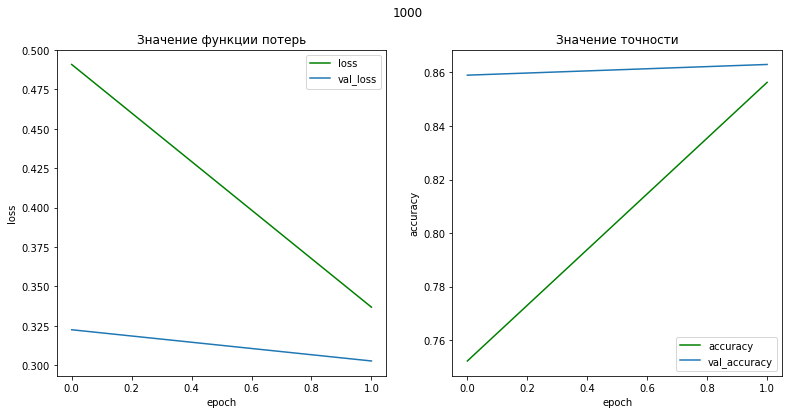

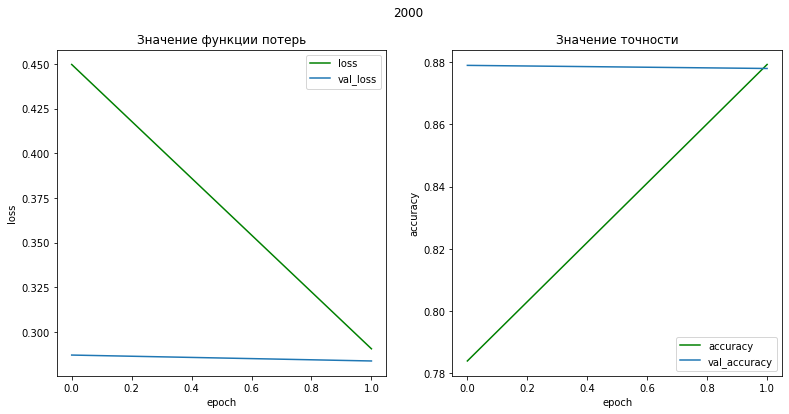

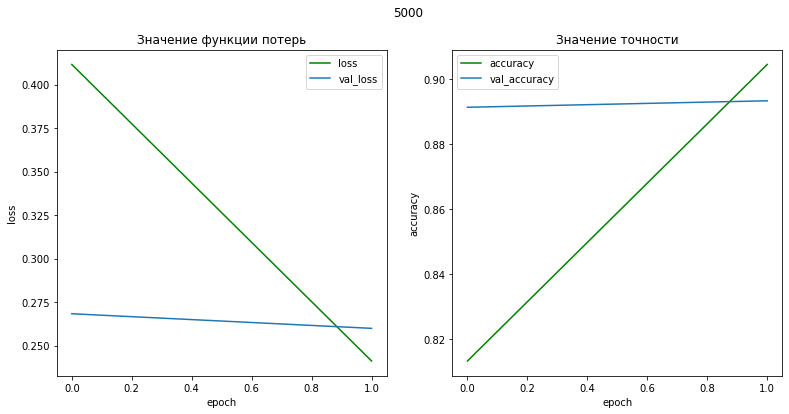

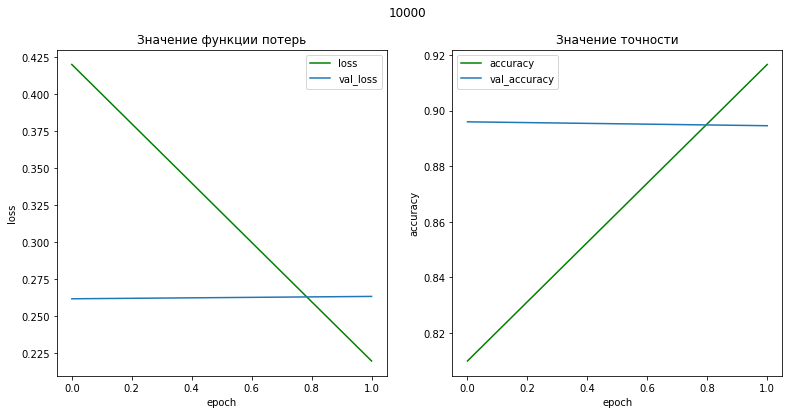

In [25]:
# Построим на графиках результаты моделей
for (model, vs) in zip(models_list, vector_sizes):
  build_plot(model.history, vs)

In [26]:
# Выведем точность работы моделей
for (model, vector_sizes) in zip(models_list, vector_sizes):
  print(vector_sizes, ":",  model.history.history['val_accuracy'][0])

1000 : 0.859000027179718
2000 : 0.8790000081062317
5000 : 0.8913999795913696
10000 : 0.8960000276565552


Напишем функцию иморта пользовательского текстового файла

In [27]:
def text_load(texts):
    dictionary = dict(imdb.get_word_index()) # Подгружаем словарь
    test_x = [] # Обьявляем массив для индексов слов
    for string in texts:
        # Меняем символы на пробелы и разделяем строку на массив слов
        words = string.replace(',', ' ').replace('.', ' ').replace('?', ' ').replace('\n', ' ').split() 
        num_words = []
        for word in words:
            word = word.lower()
            word = dictionary.get(word)
            num_words.append(word)
        test_x.append(num_words)
    return test_x

# Заменяем каждый индекс, который больше 10000 или None на 0
def vectorize_n(text):
  for j, i in enumerate(text):
    for index, value in enumerate(i):
        if value is None or value > 10000:
            text[j][index] = 0
          
  return vectorize(text, 10000)

In [28]:
reviews_text = [
    # Spider-Man: No Way Home
    ("To my surprise, it's an entertaining sequel that hooks me, without reaching paroxysm, when it delivers the nostalgia-scented pyrotechnics of the friendly neighborhood spider that faces maturity.", 1),
    # The Adam Project
    ("There's nothing as good as Back to the Future, but I think Levy finds the heart to this picture. It really works.", 1),
    # The Batman
    ("Ultimately, this Batman accepts the thankless, death-defying role he’s stepped into, and the sacrifices that go with it. But that choice would be more compelling if it weren’t framed as a tacit acknowledgement of all the inevitable sequels to come... ", 1),
    # Ambulance
    ("It has more plot-holes than plot, and no one talks or behaves like a human being, or someone in the job in which they’re employed, for one of its 136 minutes. ", 0),
    #Sonic the Hedgehog 2
    ("There are no jokes there. They’re just things you recognise. Neither does the film know what to do with Carrey. He stands around trying to turn bits of exposition into jokes by gurning and over-enunciating every line. ", 0),
    # Morbius
    ("Morbius internal conflict is brushed aside and the movies central theme is abandoned and forgotten in a chaotic mass of special effects and a mad rush to set up more sequels.", 0)
]

reviews = vectorize_n(text_load(map_(reviews_text, [0])))
review_mood = np.asarray(map_(reviews_text, [1])).astype("float32")

custom_loss, custom_acc = models_list[-1].evaluate(reviews, review_mood)

1/1 [==============================] - 0s 59ms/step - loss: 0.2823 - accuracy: 1.0000


Accuracy: 1.0


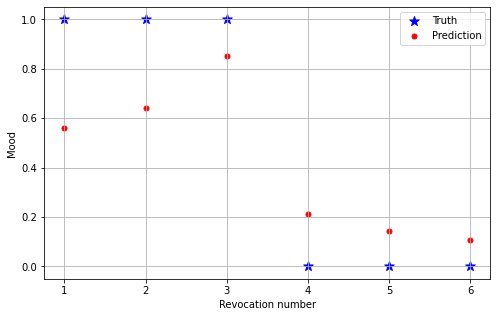

In [29]:
print('Accuracy:', custom_acc)

prediction = model.predict(reviews)
plt.figure(3, figsize=(8, 5))
plt.scatter([i + 1 for i, _ in enumerate(reviews_text)], review_mood, marker='*', c='blue', s=100, label='Truth')
plt.scatter([i + 1 for i, _ in enumerate(reviews_text)], prediction, c='red', s=25, label='Prediction')
plt.xlabel('Revocation number')
plt.ylabel('Mood')
plt.grid()
plt.legend(loc='best')

## Вывод

В результате выполнения лабораторной работы были построены модели с различным вектором представления текста, от 1000 до 10000, наиболее точной была модель с 10000 размером вектора. Также была написана функция, которая оценивает модель на основе пользовательского текста.